In [2]:
import requests

def get_binance_price():
    """바이낸스에서 SHIBUSDT 가격 가져오기"""
    url = "https://api.binance.com/api/v3/ticker/price"
    params = {"symbol": "SHIBUSDT"}
    response = requests.get(url, params=params)
    return float(response.json()["price"])

def get_upbit_price():
    """업비트에서 SHIB/KRW 가격 가져오기"""
    url = "https://api.upbit.com/v1/ticker"
    params = {"markets": "KRW-SHIB"}
    response = requests.get(url, params=params)
    return float(response.json()[0]["trade_price"])

def get_usd_to_krw():
    """신뢰할 수 있는 API에서 환율 가져오기 (네이버 금융)"""
    url = "https://api.exchangerate-api.com/v4/latest/USD"  # 신뢰할 수 있는 환율 API
    response = requests.get(url)
    data = response.json()
    return float(data["rates"]["KRW"])  # USD → KRW 환율 값


In [4]:
# 실시간 데이터 가져오기
binance_price = get_binance_price()  # 바이낸스 가격 (USDT)
upbit_price = get_upbit_price()  # 업비트 가격 (KRW)
usd_to_krw = get_usd_to_krw()  # 환율

# 김치 프리미엄 계산
kimchi_premium = ((upbit_price / (binance_price * usd_to_krw)) - 1) * 100

# 결과 출력
print(f"📌 SHIB 현재 가격 (업비트): {upbit_price} KRW")
print(f"📌 SHIB 현재 가격 (바이낸스): {binance_price} USDT")
print(f"📌 환율 (USD → KRW): {usd_to_krw}")
print(f"🔥 김치 프리미엄: {kimchi_premium:.2f}%")


📌 SHIB 현재 가격 (업비트): 0.01918 KRW
📌 SHIB 현재 가격 (바이낸스): 1.273e-05 USDT
📌 환율 (USD → KRW): 1458.82
🔥 김치 프리미엄: 3.28%


In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ✅ 📌 데이터 로드 (거래량 포함)
df = pd.read_csv("data/shib.csv")

In [18]:
df.head()

,timestamp,open,high,low,close,volume
0,2021-05-10 11:00:00,0.000014,0.000050,0.000014,0.000030,1.527431e+13
1,2021-05-10 12:00:00,0.000030,0.000039,0.000029,0.000033,1.290046e+13
2,2021-05-10 13:00:00,0.000033,0.000036,0.000029,0.000031,8.472225e+12
3,2021-05-10 14:00:00,0.000031,0.000031,0.000028,0.000029,5.786327e+12
4,2021-05-10 15:00:00,0.000029,0.000031,0.000029,0.000029,3.593920e+12


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  33444 non-null  object 
 1   open       33444 non-null  float64
 2   high       33444 non-null  float64
 3   low        33444 non-null  float64
 4   close      33444 non-null  float64
 5   volume     33444 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.5+ MB


In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ✅ 📌 데이터 로드
df = pd.read_csv("data/shib.csv")

# ✅ 📌 타임스탬프 변환
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ✅ 📌 정규화 (MinMaxScaler 적용)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[["open", "high", "low", "close", "volume"]])

# 🔥 학습 데이터 생성 (시퀀스 형태 변환)
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # 과거 시퀀스
        y.append(data[i+seq_length, 3])  # 📌 `close` 값 예측 (네 번째 컬럼)
    return np.array(X), np.array(y)

# ✅ 시퀀스 데이터 생성
SEQ_LENGTH = 50
X, y = create_sequences(scaled_data, seq_length=SEQ_LENGTH)

# ✅ 데이터 분리 (80% 학습, 10% 검증, 10% 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# ✅ 📌 새로운 LSTM 모델 정의 (거래량 포함)
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),  # 첫 번째 LSTM 레이어
    Dropout(0.2),
    LSTM(128, return_sequences=False),  # 두 번째 LSTM 레이어
    Dropout(0.2),
    Dense(64, activation="relu"),  # 완전연결층
    Dense(1)  # 출력층 (예측할 `close` 값)
])

# ✅ 모델 컴파일
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# ✅ 체크포인트 설정 (Best 모델 저장)
checkpoint = ModelCheckpoint(
    "best_model2.h5",  # 저장될 모델 파일명
    monitor="val_loss",  # 검증 손실 기준
    save_best_only=True,  # 가장 낮은 val_loss 모델만 저장
    mode="min",  # val_loss 최소화 기준
    verbose=1
)

# ✅ EarlyStopping 추가 (과적합 방지)
early_stopping = EarlyStopping(
    monitor="val_loss",  # 검증 손실 기준
    patience=5,  # 5번 연속 val_loss 감소 없으면 중단
    restore_best_weights=True,  # 가장 좋은 모델로 복구
    verbose=1
)

# ✅ 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)

# ✅ 최종 모델 저장
#model.save("final_model.h5")

# ✅ 학습 결과 확인
print(f"Training Loss: {history.history['loss'][-1]:.6f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.6f}")


Epoch 1/50


C:\Users\kj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 8.6434e-04 - mae: 0.0129
Epoch 1: val_loss improved from inf to 0.00005, saving model to best_model2.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - loss: 8.6373e-04 - mae: 0.0129 - val_loss: 4.9449e-05 - val_mae: 0.0061
Epoch 2/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.8225e-04 - mae: 0.0077
Epoch 2: val_loss did not improve from 0.00005
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 1.8226e-04 - mae: 0.0077 - val_loss: 6.0302e-05 - val_mae: 0.0068
Epoch 3/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5091e-04 - mae: 0.0074
Epoch 3: val_loss improved from 0.00005 to 0.00001, saving model to best_model2.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 1.5092e-04 - mae: 0.0074 - val_loss: 1.1654e-05 - val_mae: 0.0023
Epoch 4/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.6243e-04 - mae: 0.0079
Epoch 4: val_loss did not improve from 0.00001
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 1.6242e-04 - mae: 0.0079 - val_loss: 3.7424e-05 - val_mae: 0.0048
Epoch 5/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.5680e-04 - mae: 0.0078
Epoch 5: val_loss improved from 0.00001 to 0.00001, saving model to best_model2.h5


835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 1.5678e-04 - mae: 0.0078 - val_loss: 9.8443e-06 - val_mae: 0.0022
Epoch 6/50
835/835 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.4133e-04 - mae: 0.0075
Epoch 6: val_loss did not improve from 0.00001
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 1.4134e-04 - mae: 0.0075 - val_loss: 1.0773e-05 - val_mae: 0.0023
Epoch 7/50
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3176e-04 - mae: 0.0071
Epoch 7: val_loss did not improve from 0.00001
835/835 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - loss: 1.3181e-04 - mae: 0.0071 - val_loss: 6.4080e-05 - val_mae: 0.0072
Epoch 8/50
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3720e-04 - mae: 0.0073
Epoch 8: val_loss did not improve from 0.00001
835/835 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - loss: 1.3718e-04 - mae: 0.0073 - val_loss: 4.4469e-05 - val_mae: 0.0062
Epoch 9/50
834/835 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2586e-04 - mae: 0.0072
Epoch 9: val_loss did not improve from 0.00001


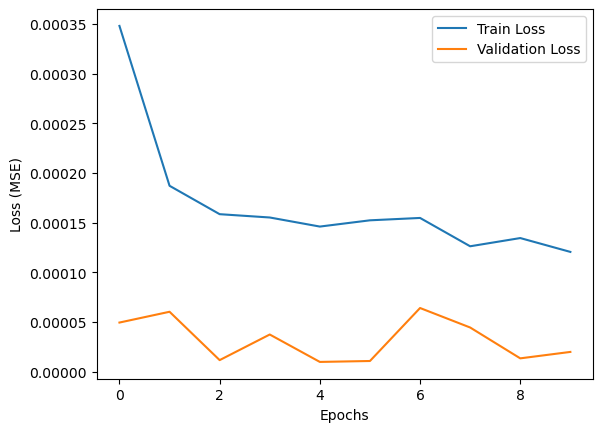

In [27]:
# ✅ 5. 학습 결과 시각화
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()


2025-03-04 06:00:00 - Predicted SHIB Price: 0.00000752 USDT / 0.0100 KRW
2025-03-04 07:00:00 - Predicted SHIB Price: 0.00000761 USDT / 0.0101 KRW
2025-03-04 08:00:00 - Predicted SHIB Price: 0.00000767 USDT / 0.0102 KRW
2025-03-04 09:00:00 - Predicted SHIB Price: 0.00000770 USDT / 0.0102 KRW
2025-03-04 10:00:00 - Predicted SHIB Price: 0.00000772 USDT / 0.0103 KRW
2025-03-04 11:00:00 - Predicted SHIB Price: 0.00000772 USDT / 0.0103 KRW
2025-03-04 12:00:00 - Predicted SHIB Price: 0.00000772 USDT / 0.0103 KRW
2025-03-04 13:00:00 - Predicted SHIB Price: 0.00000772 USDT / 0.0103 KRW
2025-03-04 14:00:00 - Predicted SHIB Price: 0.00000772 USDT / 0.0103 KRW
2025-03-04 15:00:00 - Predicted SHIB Price: 0.00000772 USDT / 0.0103 KRW


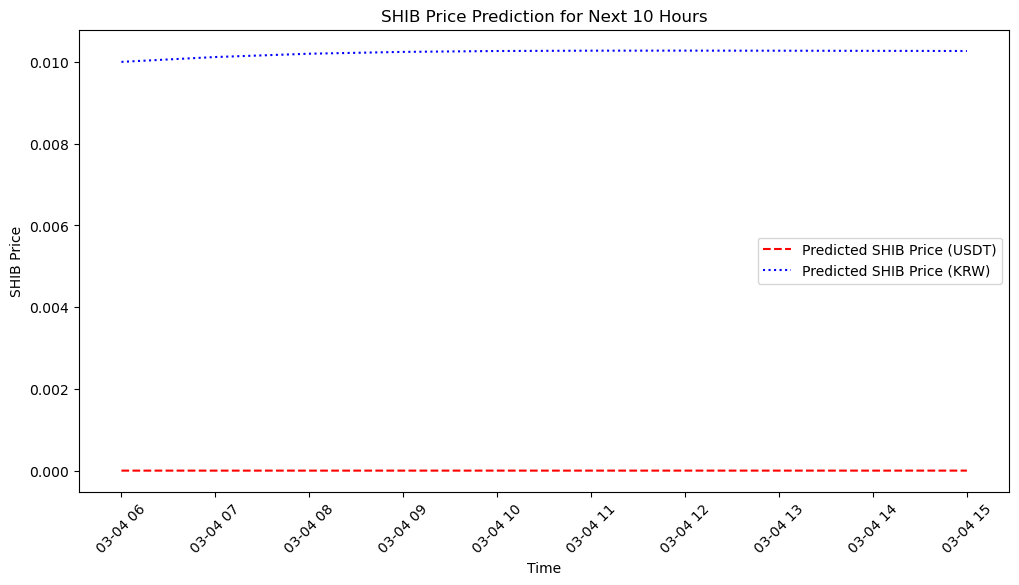

In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

# ✅ 📌 모델 로드 (손실 함수 오류 해결)
model = tf.keras.models.load_model("d250304_coinprice_model1.h5", compile=False)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

# ✅ 📌 데이터 로드
df = pd.read_csv("data/shib.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ✅ 📌 MinMaxScaler 로드 (이전 정규화 정보와 동일해야 함)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[["open", "high", "low", "close", "volume"]])

# ✅ 📌 최근 50개 데이터 가져오기 (시퀀스 생성)
SEQ_LENGTH = 50
last_sequence = scaled_data[-SEQ_LENGTH:]  # 마지막 50개 데이터
last_sequence = np.expand_dims(last_sequence, axis=0)  # (1, 50, 5) 형태

# ✅ 📌 SHIB 가격 예측 함수
def predict_future(model, last_sequence, num_steps=10, time_interval="1h", usd_to_krw=1330):
    future_preds = []
    current_sequence = last_sequence.copy()

    for _ in range(num_steps):
        # 예측 수행 (단일 `close` 가격 예측)
        next_pred = model.predict(current_sequence, verbose=0)  # (1, 1)

        # ✅ 📌 차원 문제 해결: 기존 feature 개수(5개)로 확장
        next_pred_reshaped = np.tile(next_pred, (1, 1, 5))  # (1, 1, 5) 형태로 변경

        # ✅ 📌 시퀀스 업데이트 (마지막 값 삭제 + 새로운 예측값 추가)
        current_sequence = np.concatenate((current_sequence[:, 1:, :], next_pred_reshaped), axis=1)

        future_preds.append(next_pred[0, 0])  # SHIB `close` 가격 저장

    # ✅ 📌 예측값을 원래 스케일로 변환 (inverse_transform)
    max_price = scaler.data_max_[3]  # `close` 컬럼의 최대값
    predicted_prices = np.array(future_preds) * max_price  # 역변환 수행

    # ✅ 📌 환율 적용 (달러 → 원화 변환)
    predicted_prices_krw = predicted_prices * usd_to_krw

    # ✅ 📌 시간 생성
    start_time = df["timestamp"].iloc[-1]  # 마지막 데이터의 시간
    time_steps = [start_time + timedelta(hours=i+1) for i in range(num_steps)]

    return predicted_prices, predicted_prices_krw, time_steps

# ✅ 📌 예측 수행
num_steps = 10  # 다음 10시간 예측
predicted_prices, predicted_prices_krw, future_times = predict_future(model, last_sequence, num_steps)

# ✅ 📌 예측 결과 출력
for t, price, price_krw in zip(future_times, predicted_prices, predicted_prices_krw):
    print(f"{t.strftime('%Y-%m-%d %H:%M:%S')} - Predicted SHIB Price: {price:.8f} USDT / {price_krw:.4f} KRW")

# ✅ 📌 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(future_times, predicted_prices, label="Predicted SHIB Price (USDT)", linestyle="dashed", color="red")
plt.plot(future_times, predicted_prices_krw, label="Predicted SHIB Price (KRW)", linestyle="dotted", color="blue")

plt.xlabel('Time')
plt.ylabel('SHIB Price')
plt.xticks(rotation=45)
plt.legend()
plt.title(f"SHIB Price Prediction for Next {num_steps} Hours")
plt.show()


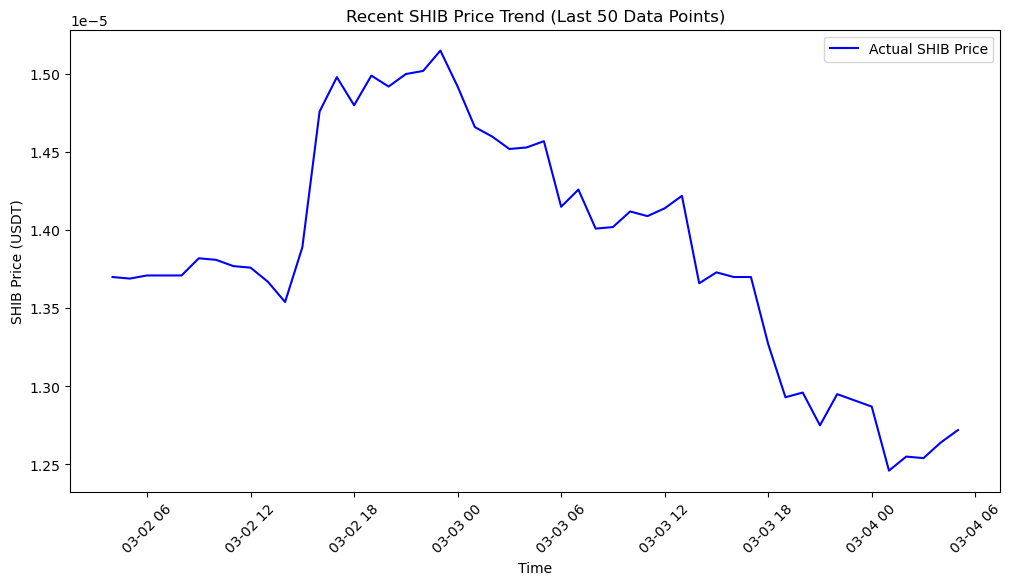

In [35]:
import matplotlib.pyplot as plt

# 최근 50개 데이터의 가격 확인
plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"].iloc[-50:], df["close"].iloc[-50:], label="Actual SHIB Price", color="blue")
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("SHIB Price (USDT)")
plt.legend()
plt.title("Recent SHIB Price Trend (Last 50 Data Points)")
plt.show()


## 예측 및 시각화